In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Requirements

In [31]:
from pandas import read_csv
from sklearn.model_selection import train_test_split
import numpy as np
!pip install transformers
from transformers import pipeline
from transformers import TFAutoModel
!pip install datasets
from datasets import Dataset, DatasetDict
!pip install tensorflow
from tensorflow.keras.layers import LSTM, Bidirectional, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load Data

In [3]:
df = read_csv('drive/MyDrive/NPL-Project-Data/dataset.csv')
df = df.dropna()
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True)

# Noisy Channel

In [ ]:
import nltk
from nltk.corpus import words
nltk.download('words')
nltk.download('punkt')

!pip install wordfreq
from wordfreq import word_frequency

import operator

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# A Space efficient Dynamic Programming
# based Python3 program to find minimum
# number operations to convert str1 to str2
def edit_distance(str1, str2):
	
	len1 = len(str1)
	len2 = len(str2)

	# Create a DP array to memoize result
	# of previous computations
	DP = [[0 for i in range(len1 + 1)]
			for j in range(2)];

	# Base condition when second String
	# is empty then we remove all characters
	for i in range(0, len1 + 1):
		DP[0][i] = i

	# Start filling the DP
	# This loop run for every
	# character in second String
	for i in range(1, len2 + 1):
		
		# This loop compares the char from
		# second String with first String
		# characters
		for j in range(0, len1 + 1):

			# If first String is empty then
			# we have to perform add character
			# operation to get second String
			if (j == 0):
				DP[i % 2][j] = i

			# If character from both String
			# is same then we do not perform any
			# operation . here i % 2 is for bound
			# the row number.
			elif(str1[j - 1] == str2[i-1]):
				DP[i % 2][j] = DP[(i - 1) % 2][j - 1]
			
			# If character from both String is
			# not same then we take the minimum
			# from three specified operation
			else:
				DP[i % 2][j] = (1 + min(DP[(i - 1) % 2][j],
									min(DP[i % 2][j - 1],
								DP[(i - 1) % 2][j - 1])))
			
	# After complete fill the DP array
	# if the len2 is even then we end
	# up in the 0th row else we end up
	# in the 1th row so we take len2 % 2
	# to get row
	return DP[len2 % 2][len1]

In [ ]:
# to find closest options for a token
english_words_set = set(words.words())

def min_distants(token):
  min_dist = len(token)
  candidates = []
  candidate_distants = []
  for w in english_words_set:
    d = edit_distance(token, w)
    if d<min_dist:
      candidates.append(w)
      candidate_distants.append(d)
      min_dist = d
  if len(candidates)==0:
    return token
  
  min_dist = min(candidate_distants)
  final_candidates = []
  for i in range(len(candidate_distants)):
    if candidate_distants[i] == min_dist:
      final_candidates.append(candidates[i])
  return final_candidates

In [ ]:
# return the item that is most frequent
def correct_token(token):
  if token in english_words_set:
    return token
  
  candidates = min_distants(token)
  if len(candidates)==1:
    return candidates[0]


  candidates_frequency = {}
  for c in candidates:
    candidates_frequency[c] = word_frequency(c, 'en')
  return max(candidates_frequency.items(), key=operator.itemgetter(1))[0]

In [ ]:
def spell_correction(text):
  tokenizer = nltk.tokenize.TreebankWordTokenizer()
  tokens = tokenizer.tokenize(text)
  new_tokens = [correct_token(t) for t in tokens]
  return ' '.join(new_tokens)

In [ ]:
spell_correction("I don't need that guyy!")

'I do nat need that guy !'

# RNNs

## Data Pre-processing

In [4]:
# Create a dictionary to convert the vocabulary (characters) to integers
vocab_to_int = {}
count = 0
for row in df['noise_sentence']:
    for character in row:
        if character not in vocab_to_int:
            vocab_to_int[character] = count
            count += 1

In [5]:
# Check the size of vocabulary and all of the values
vocab_size = len(vocab_to_int)
print("The vocabulary contains {} characters.".format(vocab_size))
print(sorted(vocab_to_int))

The vocabulary contains 75 characters.
[' ', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{']


In [6]:
# Create another dictionary to convert integers to their respective characters
int_to_vocab = {}
for character, value in vocab_to_int.items():
    int_to_vocab[value] = character

In [7]:
# This method convert sentences to integers
def create_int_sentences(sentences, max_length = 100):
  int_sentences = []
  for sentence in sentences:
    int_sentence = []
    count = 0
    for character in sentence:
        if count>=max_length:
          break
        int_sentence.append(vocab_to_int[character])
        count+=1
    if len(int_sentence)<max_length:
      int_sentence = int_sentence + ([vocab_to_int[' ']]*(max_length-len(int_sentence)))
    int_sentences.append([int_sentence])
  return np.array(int_sentences)

In [22]:
x_train = create_int_sentences(train_df['noise_sentence'][:180000])
y_train = create_int_sentences(train_df['label'][:180000])
x_test = create_int_sentences(test_df['noise_sentence'][:45000])
y_test = create_int_sentences(test_df['label'][:45000])

## Build model

In [27]:
input_size = 100
output_size = 100
dropout = 0.5
batch_size = 8
is_load = True

In [28]:
if is_load:
  model = load_model('/content/drive/MyDrive/NPL-Project-Data/lstm_model.h5')
else:
  model = Sequential()
  model.add(Bidirectional(LSTM(output_size, activation='relu', return_sequences=True, dropout=dropout),
                          merge_mode='sum',
                          input_shape=(None, input_size)))
  model.add(Bidirectional(LSTM(output_size, activation='relu', return_sequences=True,
                              dropout=dropout), merge_mode='sum'))
  model.add(Bidirectional(LSTM(output_size, activation='relu', return_sequences=True,
                              dropout=dropout), merge_mode='sum'))
  model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mse'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, None, 100)        160800    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, None, 100)        160800    
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, None, 100)        160800    
 nal)                                                            
                                                                 
Total params: 482,400
Trainable params: 482,400
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
22500/22500 [==============================] - 243s 10ms/step - loss: 59.5593 - mse: 59.5593 - val_loss: 57.1209 - val_mse: 57.1209
Epoch 2/10
22500/22500 [==============================] - 190s 8ms/step - loss: 57.7928 - mse: 57.7928 - val_loss: 57.4456 - val_mse: 57.4456
Epoch 3/10
22500/22500 [==============================] - 189s 8ms/step - loss: 57.5567 - mse: 57.5567 - val_loss: 56.8419 - val_mse: 56.8419
Epoch 4/10
22500/22500 [==============================] - 198s 9ms/step - loss: 57.3503 - mse: 57.3503 - val_loss: 57.2806 - val_mse: 57.2806
Epoch 5/10
22500/22500 [==============================] - 191s 9ms/step - loss: 57.1686 - mse: 57.1686 - val_loss: 56.6566 - val_mse: 56.6566
Epoch 6/10
22500/22500 [==============================] - 192s 9ms/step - loss: 57.0199 - mse: 57.0199 - val_loss: 57.4254 - val_mse: 57.4254
Epoch 7/10
22500/22500 [==============================] - 192s 9ms/step - loss: 56.8851 - mse: 56.8851 - val_loss: 56.7279 - val_mse: 56.7279
Epoch

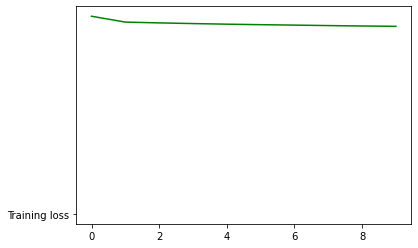

In [29]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=batch_size)
model.save('/content/drive/MyDrive/NPL-Project-Data/lstm_model.h5')
plt.plot(history.epoch, history.history['loss'], 'g', 'Training loss')

In [42]:
train_df['noise_sentence'][12]

'Modal theories of ability for example focus on what os possible for the agent to do'

In [43]:
x_train[12]

array([[35,  5, 30, 10,  2,  3, 16,  6, 44, 17, 20, 43,  6, 40, 11, 17,
        17,  3,  6, 34,  8,  8,  9, 22,  3,  6,  2,  4,  3,  6, 60, 17,
        10,  6,  4,  8,  6, 14, 18,  8,  9, 32,  6,  8,  4, 16,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6]])

In [49]:
sample = x_train[12].reshape((1,1,100))
res = ''
for i in np.squeeze(sample):
  res+=int_to_vocab[i]
print(res)

res = ''
for i in np.squeeze(model.predict(sample)):
  res+=int_to_vocab[round(i)]
print(res)

Ro6mans Nick Stiin Heer2n adn Wim de Clerq eds                                                      
Kytyyyyyyyttttttttmmmmmrmmmmrrrrrrreeeeeeeeebebebbbb bbbbb                          o               


# Transformers

In [ ]:
my_dataset = DatasetDict()
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df, split='test')
my_dataset['train'] = train_ds
my_dataset['test'] = test_ds
my_dataset

DatasetDict({
    train: Dataset({
        features: ['noise_sentence', 'label', '__index_level_0__'],
        num_rows: 180707
    })
    test: Dataset({
        features: ['noise_sentence', 'label', '__index_level_0__'],
        num_rows: 45177
    })
})

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def my_tokenize_function(examples):
    return tokenizer(examples["noise_sentence"], padding="max_length", truncation=True)

my_tokenized_datasets = my_dataset.map(my_tokenize_function, batched=True)

  0%|          | 0/650 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

In [ ]:
tf_train_dataset = my_tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=True,
    batch_size=8,
)

tf_test_dataset = my_tokenized_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    batch_size=8,
)

In [ ]:
my_model = TFAutoModel.from_pretrained('murali1996/bert-base-cased-spell-correction', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.weight', 'bert.embeddings.position_ids', 'classifier.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Import generic wrappers
from transformers import AutoModel, AutoTokenizer 


# Define the model repo
model_name = "murali1996/bert-base-cased-spell-correction" 


# Download pytorch model
model = TFAutoModel.from_pretrained('murali1996/bert-base-cased-spell-correction', from_pt=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)


# Transform input tokens 
inputs = tokenizer("Hello world! I am Arman and I really want to introduce you someting", return_tensors="tf")

# Model apply
outputs = model(**inputs)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.weight', 'bert.embeddings.position_ids', 'classifier.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss) # can also use any keras loss fn
model.fit(tf_train_dataset, epochs=3, batch_size=16)